## Домашнее задание
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать feature engineering
3. обучить любой классификатор (какой вам нравится)
4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
5. применить random negative sampling для построения классификатора в новых условиях
6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

https://archive.ics.uci.edu/ml/datasets/Ionosphere

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("ionosphere.data", header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g


In [131]:
df.shape

(351, 35)

In [132]:
df.iloc[:, -1].value_counts()

g    225
b    126
Name: 34, dtype: int64

In [133]:
df[34].replace(('g', 'b'), (1, 0), inplace=True)

In [134]:
df.iloc[:, -1].value_counts()

1    225
0    126
Name: 34, dtype: int64

<AxesSubplot:>

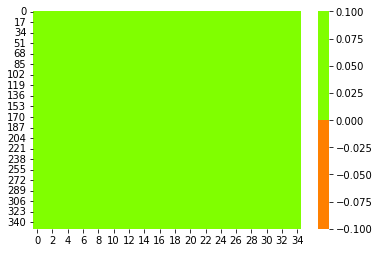

In [135]:
colours = ['#FF8000', '#80FF00']    
sns.heatmap(df[df.columns].isnull(), cmap=sns.color_palette(colours))

Отсутствующих значений в датасете нет

In [136]:
# разобьем на тренировочную и тестовую

from sklearn.model_selection import train_test_split

x_data = df.iloc[:,:-1]
y_data = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [137]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=7)

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

In [138]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score
# Функция оценки качества 

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    metrics = (f1, roc, rec, prc)
    
    return metrics

# Оценка полученных результатов
    
results = evaluate_results(y_test, y_predict)
results

Classification results:
f1: 95.92%
roc: 92.44%
recall: 97.92%
precision: 94.00%


(0.9591836734693877, 0.9243659420289855, 0.9791666666666666, 0.94)

### PU learning

In [139]:
def pu_learn(p_num):
    
    mod_df = df.copy()
    pos_ind = np.where(mod_df.iloc[:,-1].values == 1)[0]
    np.random.shuffle(pos_ind)
    pos_sample_len = int(np.ceil(p_num * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]

    # Добавим столбец новой целевой переменной class_test, где 1 - выбранные ранее позитивные значения (P), -1 - остальные (U)
    mod_df['class_test'] = -1
    mod_df.loc[pos_sample,'class_test'] = 1
    print('target variable:\n', mod_df.iloc[:,-1].value_counts())
    
    # random negative sampling
    mod_df = mod_df.sample(frac=1)
    neg_sample = mod_df[mod_df['class_test']==-1][:len(mod_df[mod_df['class_test']==1])]
    sample_test = mod_df[mod_df['class_test']==-1][len(mod_df[mod_df['class_test']==1]):]
    pos_sample = mod_df[mod_df['class_test']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    # Обучение модели и получение предсказания

    model = LGBMClassifier(random_state=7)

    model.fit(sample_train.iloc[:,:-2].values, 
                sample_train.iloc[:,-2].values)
    y_predict = model.predict(sample_test.iloc[:,:-2].values)
    y_test = sample_test.iloc[:,-2].values
    
    return y_test, y_predict

In [140]:
# P = 10%
y_test, y_predict = pu_learn(0.1)
results_10  = evaluate_results(y_test, y_predict)
results_10

target variable:
 -1    328
 1     23
Name: class_test, dtype: int64
Classification results:
f1: 82.82%
roc: 70.79%
recall: 94.12%
precision: 73.95%


(0.8282352941176471, 0.707876370887338, 0.9411764705882353, 0.7394957983193278)

In [141]:
# P = 15%
y_test, y_predict = pu_learn(0.15)
results_15  = evaluate_results(y_test, y_predict)
results_15

target variable:
 -1    317
 1     34
Name: class_test, dtype: int64
Classification results:
f1: 87.15%
roc: 76.78%
recall: 99.43%
precision: 77.58%


(0.871536523929471, 0.7677686386164715, 0.9942528735632183, 0.7757847533632287)

In [142]:
# P = 20%
y_test, y_predict = pu_learn(0.2)
results_20  = evaluate_results(y_test, y_predict)
results_20

target variable:
 -1    306
 1     45
Name: class_test, dtype: int64
Classification results:
f1: 90.00%
roc: 84.26%
recall: 98.71%
precision: 82.70%


(0.9, 0.8426049908703591, 0.9870967741935484, 0.827027027027027)

In [143]:
# P = 25%
y_test, y_predict = pu_learn(0.25)
results_25  = evaluate_results(y_test, y_predict)
results_25

target variable:
 -1    294
 1     57
Name: class_test, dtype: int64
Classification results:
f1: 90.00%
roc: 87.25%
recall: 95.45%
precision: 85.14%


(0.9, 0.8725108225108225, 0.9545454545454546, 0.8513513513513513)

In [144]:
# P = 30%
y_test, y_predict = pu_learn(0.3)
results_30  = evaluate_results(y_test, y_predict)
results_30

target variable:
 -1    283
 1     68
Name: class_test, dtype: int64
Classification results:
f1: 90.98%
roc: 87.22%
recall: 99.18%
precision: 84.03%


(0.9097744360902256,
 0.8722457253657677,
 0.9918032786885246,
 0.8402777777777778)

In [145]:
# P = 35%
y_test, y_predict = pu_learn(0.35)
results_35  = evaluate_results(y_test, y_predict)
results_35

target variable:
 -1    272
 1     79
Name: class_test, dtype: int64
Classification results:
f1: 91.48%
roc: 89.51%
recall: 99.03%
precision: 85.00%


(0.9147982062780268, 0.8951456310679613, 0.9902912621359223, 0.85)

In [146]:
# P = 40%
y_test, y_predict = pu_learn(0.4)
results_40  = evaluate_results(y_test, y_predict)
results_40

target variable:
 -1    261
 1     90
Name: class_test, dtype: int64
Classification results:
f1: 90.16%
roc: 88.59%
recall: 98.86%
precision: 82.86%


(0.9015544041450777,
 0.8858844468784228,
 0.9886363636363636,
 0.8285714285714286)

In [147]:
all_metrics = (results, results_10, results_15, results_20, results_25, results_30, results_35, results_40)
table_metrics = pd.DataFrame(list(all_metrics), 
            columns=["f-score", "roc-auc", "recall", "precision"], 
            index=["Base", "P = 10%", "P = 15%", "P = 20%", "P = 25%", "P = 30%", "P = 35%","P = 40%"])

table_metrics

,f-score,roc-auc,recall,precision
Base,0.959184,0.924366,0.979167,0.940000
P = 10%,0.828235,0.707876,0.941176,0.739496
P = 15%,0.871537,0.767769,0.994253,0.775785
P = 20%,0.900000,0.842605,0.987097,0.827027
P = 25%,0.900000,0.872511,0.954545,0.851351
P = 30%,0.909774,0.872246,0.991803,0.840278
P = 35%,0.914798,0.895146,0.990291,0.850000
P = 40%,0.901554,0.885884,0.988636,0.828571


### Вывод: Прирост в качестве достигается при P = 20%, дальнейшее увеличение P дает минимальные приросты.